# Requirment analysis agent
Get requirment from the client and make questions and make a report about the requirement

## 1. Get user need as message and generate sub-parts to explore more

This sub graph generate sub headings from the user need.

These generated sub heading leater used for more clrarifications of user requirements.

### 1. Setup the environment

In [1]:
# connect with gemini api
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
# initialize llm chat model
from langchain_google_genai import ChatGoogleGenerativeAI
from google.genai.types import GenerateContentConfig


system_instruction = """
                        You are a phone-agent assistant.  
                        
                        Keep all messages very short—just a single question or brief answer.  
                        
                        Act as if you’re on a live call: no long explanations or chit-chat.  
                        
                        Always reference prior chat context and stay aligned with the conversation.  
                        
                    """

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    config=GenerateContentConfig(
        system_instruction=system_instruction,
    ),
    # other params...
)

In [6]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [8]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
import operator
from typing import Annotated

class GeneratedSubHeading(BaseModel):
    generated_sub_heading: str = Field(None, description="generated sub part for understand the user need.")

# sub graph state
class SubHeadingState(MessagesState):
    max_generated_sub_headings: int # Number of generated queries
    generated_sub_headings: List[GeneratedSubHeading] # Generated questions
    current_focus: str # current forcus to genrate question
    topic: str # current topic to generate report
    report: Annotated[list, operator.add] # list of the parts of final report

class Perspectives(BaseModel):
    sub_headings: List[GeneratedSubHeading] = Field(
        description="Comprehensive list of sub part headings that align with user need.",
    )

In [9]:
generate_sub_headings_instructions = """You are an caller agent user call for specific need.
                                 
                                 So you need do identify sub parts of the user need and generate sub part headings for get good understand about user need.

                                 You need to generate maximum {max_sub_parts} sub parts to get clear understand about user need.
                                 
                                 """

In [7]:
# test for question generation.
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Make the system message
system_message = generate_sub_headings_instructions.format(max_sub_parts=5)

# Enforce structured output
structured_llm = llm.with_structured_output(Perspectives)

# Generate question 
queries = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate sub part headings.")]+ [HumanMessage(content="I want to build a website")])

In [8]:
print(queries.sub_headings)

[GeneratedSubHeading(generated_sub_heading='Purpose of the website'), GeneratedSubHeading(generated_sub_heading='Target audience'), GeneratedSubHeading(generated_sub_heading='Key features'), GeneratedSubHeading(generated_sub_heading='Content strategy'), GeneratedSubHeading(generated_sub_heading='Technical requirements')]


In [10]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def generate_sub_headings(state: SubHeadingState):
    # define the variables
    max_sub_headings=state["max_generated_sub_headings"]

    # get the history of the messages
    messages = state.get('messages', [])
    if not messages:
        raise ValueError("The 'messages' list is empty. Cannot generate subheadings without a conversation history.")

    # get the last message
    message = messages[-1]


    # get the structed output
    system_message = generate_sub_headings_instructions.format(max_sub_parts=max_sub_headings)

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # Generate question 
    subheadings = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate sub part headings.")]+[message])
    
    # update the state
    return {"generated_sub_headings": subheadings}

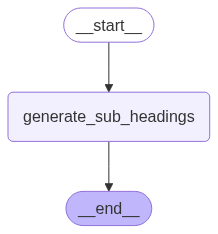

In [11]:
# make a subgraph to generate subheading based on the user need
GenerateSubHeadingBuilder = StateGraph(SubHeadingState)
GenerateSubHeadingBuilder.add_node("generate_sub_headings", generate_sub_headings)

# make connections
GenerateSubHeadingBuilder.add_edge(START,"generate_sub_headings")
GenerateSubHeadingBuilder.add_edge("generate_sub_headings",END)

# compile
memory = MemorySaver()
graph = GenerateSubHeadingBuilder.compile(checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
# sample graph invoke
thread = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": [HumanMessage(content="I want to build a mobile app")], "max_generated_sub_headings": 10}, thread)

{'messages': [HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='bc1f1b26-0a68-4aa5-afa7-a5e202292c56')],
 'max_generated_sub_headings': 10,
 'generated_sub_headings': Perspectives(sub_headings=[GeneratedSubHeading(generated_sub_heading='App Functionality'), GeneratedSubHeading(generated_sub_heading='Target Audience'), GeneratedSubHeading(generated_sub_heading='Platform (iOS, Android, or both)'), GeneratedSubHeading(generated_sub_heading='Development Budget'), GeneratedSubHeading(generated_sub_heading='Monetization Strategy'), GeneratedSubHeading(generated_sub_heading='Timeline for Development'), GeneratedSubHeading(generated_sub_heading='Required Features'), GeneratedSubHeading(generated_sub_heading='Design Preferences'), GeneratedSubHeading(generated_sub_heading='Marketing Plan'), GeneratedSubHeading(generated_sub_heading='Maintenance and Updates')])}

## 2. Make sub headings as topics make a conversation with user.

This sub graph use the generated sub headings to explore more about this topic with the customer.

In [ ]:
last_state = {'messages': [HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='5decbfe6-0788-4a81-a852-23a41bd84988'),
            HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='15ff0fa4-0ca9-48bb-97cf-1b1f66a9a338'),
            HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='55b2969b-6f88-4370-a1a5-46bdf94bc4a7'),
            HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='cdf39020-1ec1-4977-b3b5-ed3dab1336bd')],
            'max_generated_sub_headings': 10,
            'generated_sub_headings': Perspectives(sub_headings=[GeneratedSubHeading(generated_sub_heading='App Functionality'), GeneratedSubHeading(generated_sub_heading='Target Audience'), GeneratedSubHeading(generated_sub_heading='Platform (iOS, Android, or both)'), GeneratedSubHeading(generated_sub_heading='Development Budget'), GeneratedSubHeading(generated_sub_heading='Monetization Strategy'), GeneratedSubHeading(generated_sub_heading='Timeline for Development'), GeneratedSubHeading(generated_sub_heading='Required Features'), GeneratedSubHeading(generated_sub_heading='Design Preferences'), GeneratedSubHeading(generated_sub_heading='Marketing Plan'), GeneratedSubHeading(generated_sub_heading='Maintenance and Updates')])}

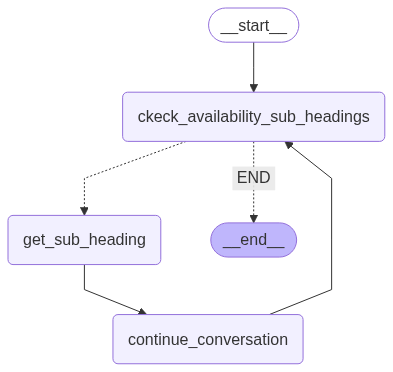

In [12]:
# add dummy node for add the condition check
def ckeck_availability_sub_headings(state: SubHeadingState):
    # dummy node
    return state

# sub_headings check for availability if available go to the get sub heading 
# else end
def availability_sub_headings(state: SubHeadingState):
    # check the sub headings are available 
    sub_headings = state.pop('generated_sub_headings', [])

    # if not go to the end
    if len(sub_headings.sub_headings) == 0:
        return "END"
    
    # otherwise return get_sub_headig node
    return "get_sub_heading"

# this method get the sub heading from the list and make it current forcus
def get_sub_heading(state: SubHeadingState):
    # get the current sub heading one by one
    sub_headings = state.pop('generated_sub_headings', [])
    
    # popped sub heading should mark as the new focus in the conversation 
    current_focus = sub_headings.sub_headings[0].generated_sub_heading

    # these subheadings are the remaining subheadings
    if len(sub_headings.sub_headings) <= 1:
        # if there is only one element 
        sub_headings.sub_headings = []
    else:
        # else more than one
        sub_headings.sub_headings = sub_headings.sub_headings[1:]
    
    return {'generated_sub_headings':sub_headings, 'current_focus':current_focus}

# this method continue the conversation 
def continue_conversation(state: SubHeadingState):
    
    # get the current forcus and make a question 
    current_focus = state.get("current_focus","")

    # this function continue the chat with user with different sub headings
    generate_question = """
                        Ask the user one focused question based on {current_focus}.

                        Only ask question do not need to provide examples.
                        
                        """
    
    # history messages
    messages = state.get("messages", [])
    print(messages)
    
    # make the system message to 
    system_message = generate_question.format(current_focus=current_focus)

    # invoke the model with the history 
    question = llm.invoke(messages + [system_message])
    print("assistant: ",question.content)

    # answer to the question 
    user_reply = input("user: ")
    print("user: ", user_reply)
    
    # update the messages with ai question and the human response
    return {'messages': [question, HumanMessage(user_reply)]}    
    

# make a subgraph to generate subheading based on the user need
ContinueConversationBuilder = StateGraph(SubHeadingState)
ContinueConversationBuilder.add_node("get_sub_heading", get_sub_heading)
ContinueConversationBuilder.add_node("continue_conversation", continue_conversation)
ContinueConversationBuilder.add_node("ckeck_availability_sub_headings", ckeck_availability_sub_headings)

# make connections
ContinueConversationBuilder.add_edge(START, "ckeck_availability_sub_headings")
ContinueConversationBuilder.add_conditional_edges("ckeck_availability_sub_headings", availability_sub_headings,
                                                {"END": END, "get_sub_heading": "get_sub_heading"})
ContinueConversationBuilder.add_edge("get_sub_heading", "continue_conversation")
ContinueConversationBuilder.add_edge("continue_conversation", "ckeck_availability_sub_headings")

# compile
memory = MemorySaver()
graph = ContinueConversationBuilder.compile(checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [76]:
# sample graph invoke
thread = {"configurable": {"thread_id": "1"},"recursion_limit": 100}
graph.invoke({"max_generated_sub_headings": 10,'generated_sub_headings': Perspectives(sub_headings=[GeneratedSubHeading(generated_sub_heading='App Functionality'), GeneratedSubHeading(generated_sub_heading='Target Audience'), GeneratedSubHeading(generated_sub_heading='Platform (iOS, Android, or both)'), GeneratedSubHeading(generated_sub_heading='Development Budget'), GeneratedSubHeading(generated_sub_heading='Monetization Strategy'), GeneratedSubHeading(generated_sub_heading='Timeline for Development'), GeneratedSubHeading(generated_sub_heading='Required Features'), GeneratedSubHeading(generated_sub_heading='Design Preferences'), GeneratedSubHeading(generated_sub_heading='Marketing Plan'), GeneratedSubHeading(generated_sub_heading='Maintenance and Updates')])}, thread)

[]
assistant:  Based on your app's functionality, what is the primary action a user would take after successfully logging in?
user:  mobile 
[AIMessage(content="Based on your app's functionality, what is the primary action a user would take after successfully logging in?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--41ae9dd7-2e40-49a4-b998-4f8b2e9fae43-0', usage_metadata={'input_tokens': 29, 'output_tokens': 23, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='mobile ', additional_kwargs={}, response_metadata={}, id='e4100adb-fd1e-44ba-b9e6-dbbb580804de')]
assistant:  What is the main reason you use mobile apps?
user:  no
[AIMessage(content="Based on your app's functionality, what is the primary action a user would take after successfully logging in?", additional_kwargs={}, response_metadata={'prom

{'messages': [AIMessage(content="Based on your app's functionality, what is the primary action a user would take after successfully logging in?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--41ae9dd7-2e40-49a4-b998-4f8b2e9fae43-0', usage_metadata={'input_tokens': 29, 'output_tokens': 23, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='mobile ', additional_kwargs={}, response_metadata={}, id='e4100adb-fd1e-44ba-b9e6-dbbb580804de'),
  AIMessage(content='What is the main reason you use mobile apps?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--854efa14-ba05-4566-ac21-dd00115b7a4e-0', usage_metadata={'input_tokens': 53, 'output_tokens': 11, 'total_t

## 3. Get the user conversation and write a report

This sub graph get the questions and answers from the users and make a report.

In [13]:

system_instruction = """
                        You have to follow the instruction given.  
                        
                        Do not add unnecessary things like "based on our conversation, suitable for inclusion".
                        
                        Only add the heading and give the content.
                        
                    """

report_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    config=GenerateContentConfig(
        system_instruction=system_instruction,
    ),
)

In [14]:
from langgraph.constants import Send

# generate report
def continue_to_report(state: SubHeadingState):
    # general sub parts of the report
    report_parts = ["Summery", "Functional Requirements", "Non-functional Requirements"]
    # simultaneously generate report based on messages
    return [Send("generate_report", {"topic": s,"messages":  state.get("messages")}) for s in report_parts]

In [19]:
# call for report llm to generate each part of the report
def generate_report(state: SubHeadingState):
    report_prompt = """
                    make a part of the report based on the conversation provide in above.

                    Sub topic of the report is {topic}.

                    Do not add unnecessary things like "based on our conversation, suitable for inclusion".
                        
                    Only add the heading and give the content.

                    """
    # format the prompt
    formatted_prompt = report_prompt.format(topic = state.get("topic"))
    print(state.get("topic"))
    messages = state.get("messages")
    print(messages)
    # generate output
    response = report_llm.invoke(state.get("messages") + [formatted_prompt])
    print(response)
    # update the state
    return {"report": [response]}

In [18]:
report_prompt = """
                    make a part of the report based on the conversation provide in above.

                    Sub topic of the report is {topic}.

                    Do not add unnecessary things like "based on our conversation, suitable for inclusion".
                        
                    Only add the heading and give the content.

                    """
# format the prompt
formatted_prompt = report_prompt.format(topic = "Summery")
# generate output
response = report_llm.invoke([HumanMessage(content='I want to build a website healthcare', additional_kwargs={}, response_metadata={}, id='6ae155fb-377d-42c0-bdce-e2b3edfe8b65'),
  AIMessage(content='Who is your target audience for this healthcare website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--e65a51ce-eb89-4c86-a9e8-264315d93c0c-0', usage_metadata={'input_tokens': 36, 'output_tokens': 11, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='patients', additional_kwargs={}, response_metadata={}, id='8a5c2f23-5732-445c-9add-3f1ac51b77ff'),
  AIMessage(content='What specific healthcare services or information will your website primarily offer to patients?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--b935f752-0e4a-4cb4-84f5-814161679829-0', usage_metadata={'input_tokens': 47, 'output_tokens': 15, 'total_tokens': 62, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='patient can register and connect with doctors', additional_kwargs={}, response_metadata={}, id='2f53d830-9ce7-4518-9c09-b37e12a3fa7e'),
  AIMessage(content='What information will patients need to provide during registration?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--891ef372-ccb4-48f0-947d-9edc5d88480b-0', usage_metadata={'input_tokens': 68, 'output_tokens': 11, 'total_tokens': 79, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='no', additional_kwargs={}, response_metadata={}, id='8c72ed90-a3fb-4754-9c02-3bbc072897de'),
  AIMessage(content='What are the key patient needs and pain points that your website aims to address?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--c1b49ae9-8efe-4325-8521-5d319bf70856-0', usage_metadata={'input_tokens': 79, 'output_tokens': 17, 'total_tokens': 96, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='appoinment to doctors', additional_kwargs={}, response_metadata={}, id='2cb314ca-eab7-461b-a86c-42ae254257ee'),
  AIMessage(content='What level of technical expertise do you have in web development?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--6262b45a-0b77-4348-9efe-f878d0c63a99-0', usage_metadata={'input_tokens': 100, 'output_tokens': 13, 'total_tokens': 113, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='no', additional_kwargs={}, response_metadata={}, id='0570a218-c519-41bc-870c-373cedf9ab41'),
  AIMessage(content='What kind of experience do you want patients to have when they first visit your website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--f960eee2-de1d-421c-983d-5c96d816f4d7-0', usage_metadata={'input_tokens': 115, 'output_tokens': 18, 'total_tokens': 133, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='simple ', additional_kwargs={}, response_metadata={}, id='20914390-9a70-48ad-a8e3-93a9f7ae2e6d'),
  AIMessage(content='Will your website handle any Protected Health Information (PHI) as defined by HIPAA?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--7aadc36d-ee44-4a37-9033-1efd48e70832-0', usage_metadata={'input_tokens': 132, 'output_tokens': 17, 'total_tokens': 149, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='addf2c8e-d3c7-4572-8823-bc0ed3138e44'),
  AIMessage(content='Will you be charging patients a fee for using the appointment booking service?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--27caa858-eb7d-478d-924a-a83490bc395a-0', usage_metadata={'input_tokens': 150, 'output_tokens': 15, 'total_tokens': 165, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='based on the doctor change that', additional_kwargs={}, response_metadata={}, id='ad1584bf-759d-493f-846d-4b53e819dd2b'),
  AIMessage(content='What channels will you use to reach your target audience of patients and promote your website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--efcda173-98dd-49c6-8d5e-7c193afd3bad-0', usage_metadata={'input_tokens': 170, 'output_tokens': 18, 'total_tokens': 188, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='no', additional_kwargs={}, response_metadata={}, id='9e84b282-6bc3-4452-83c3-41aafdabf6c7'),
  AIMessage(content='How frequently do you anticipate needing to update doctor availability and information on your website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--ad2d3aa3-7e35-4f51-bcd4-f733e1ec4f89-0', usage_metadata={'input_tokens': 188, 'output_tokens': 17, 'total_tokens': 205, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='5 months', additional_kwargs={}, response_metadata={}, id='48139c20-1355-4235-9543-7c7899295227')] + [formatted_prompt])

print(response)

content='### Summary\n\nThe envisioned website aims to connect patients with doctors for appointment booking. The website should be simple to use. The appointment booking service may involve fees that vary based on the doctor. The website will handle Protected Health Information (PHI) and will need to be HIPAA compliant. Doctor availability and information will be updated approximately every 5 months. The user has no web development experience and does not have a marketing plan. Patient registration will not require any information.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []} id='run--8fd36919-1f52-4765-85ea-42464ec2819e-0' usage_metadata={'input_tokens': 236, 'output_tokens': 93, 'total_tokens': 329, 'input_token_details': {'cache_read': 0}}


In [20]:
# dummy node after the start
# can not get the messages error
def continue_report(state: SubHeadingState):
    return state

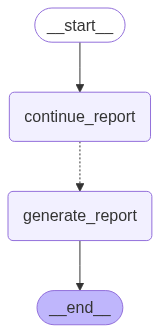

In [25]:
# make the graph
ReportBuilder = StateGraph(SubHeadingState)
ReportBuilder.add_node("generate_report", generate_report)
ReportBuilder.add_node("continue_report", continue_report)

# make the connections
ReportBuilder.add_edge(START, "continue_report")
ReportBuilder.add_conditional_edges("continue_report", continue_to_report, ["generate_report"])
ReportBuilder.add_edge("generate_report", END)

# compile the graph
report_builder_graph = ReportBuilder.compile()

# display 
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [22]:
thread = {"configurable": {"thread_id": "1"},"recursion_limit": 100}
graph.invoke({"messages": [HumanMessage(content="I want to build a mobile app")], "max_generated_sub_headings": 10}, thread)

Summery
[HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='793778b2-3dea-4118-9655-6c25bc1de3a7')]
Functional Requirements
[HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='793778b2-3dea-4118-9655-6c25bc1de3a7')]
Non-functional Requirements
[HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='793778b2-3dea-4118-9655-6c25bc1de3a7')]
content='Okay, I\'m ready. Please provide the conversation about the mobile app you want to build. Once you provide the conversation, I will generate the "Functional Requirements" section for your report.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []} id='run--69282e2f-037e-4c59-9846-2a6ae516aa3a-0' usage_metadata={'input_tokens': 67, 'output_tokens': 40, 'total_tokens':

{'messages': [HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='793778b2-3dea-4118-9655-6c25bc1de3a7')],
 'max_generated_sub_headings': 10,
 'report': [AIMessage(content='Okay, I understand. Please provide the conversation you\'d like me to summarize for the "Summary" subtopic of your mobile app development report. I will then generate the content for that section, focusing solely on the key points discussed.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--50c3ac14-6965-4562-ad23-3eddae121f38-0', usage_metadata={'input_tokens': 67, 'output_tokens': 49, 'total_tokens': 116, 'input_token_details': {'cache_read': 0}}),
  AIMessage(content='Okay, I\'m ready. Please provide the conversation about the mobile app you want to build. Once you provide the conversation, I will generate the "Functi

In [23]:
thread = {"configurable": {"thread_id": "1"},"recursion_limit": 100}
graph.invoke({"messages": [HumanMessage(content='I want to build a website healthcare', additional_kwargs={}, response_metadata={}, id='6ae155fb-377d-42c0-bdce-e2b3edfe8b65'),
  AIMessage(content='Who is your target audience for this healthcare website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--e65a51ce-eb89-4c86-a9e8-264315d93c0c-0', usage_metadata={'input_tokens': 36, 'output_tokens': 11, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='patients', additional_kwargs={}, response_metadata={}, id='8a5c2f23-5732-445c-9add-3f1ac51b77ff'),
  AIMessage(content='What specific healthcare services or information will your website primarily offer to patients?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--b935f752-0e4a-4cb4-84f5-814161679829-0', usage_metadata={'input_tokens': 47, 'output_tokens': 15, 'total_tokens': 62, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='patient can register and connect with doctors', additional_kwargs={}, response_metadata={}, id='2f53d830-9ce7-4518-9c09-b37e12a3fa7e'),
  AIMessage(content='What information will patients need to provide during registration?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--891ef372-ccb4-48f0-947d-9edc5d88480b-0', usage_metadata={'input_tokens': 68, 'output_tokens': 11, 'total_tokens': 79, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='no', additional_kwargs={}, response_metadata={}, id='8c72ed90-a3fb-4754-9c02-3bbc072897de'),
  AIMessage(content='What are the key patient needs and pain points that your website aims to address?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--c1b49ae9-8efe-4325-8521-5d319bf70856-0', usage_metadata={'input_tokens': 79, 'output_tokens': 17, 'total_tokens': 96, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='appoinment to doctors', additional_kwargs={}, response_metadata={}, id='2cb314ca-eab7-461b-a86c-42ae254257ee'),
  AIMessage(content='What level of technical expertise do you have in web development?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--6262b45a-0b77-4348-9efe-f878d0c63a99-0', usage_metadata={'input_tokens': 100, 'output_tokens': 13, 'total_tokens': 113, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='no', additional_kwargs={}, response_metadata={}, id='0570a218-c519-41bc-870c-373cedf9ab41'),
  AIMessage(content='What kind of experience do you want patients to have when they first visit your website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--f960eee2-de1d-421c-983d-5c96d816f4d7-0', usage_metadata={'input_tokens': 115, 'output_tokens': 18, 'total_tokens': 133, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='simple ', additional_kwargs={}, response_metadata={}, id='20914390-9a70-48ad-a8e3-93a9f7ae2e6d'),
  AIMessage(content='Will your website handle any Protected Health Information (PHI) as defined by HIPAA?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--7aadc36d-ee44-4a37-9033-1efd48e70832-0', usage_metadata={'input_tokens': 132, 'output_tokens': 17, 'total_tokens': 149, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='addf2c8e-d3c7-4572-8823-bc0ed3138e44'),
  AIMessage(content='Will you be charging patients a fee for using the appointment booking service?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--27caa858-eb7d-478d-924a-a83490bc395a-0', usage_metadata={'input_tokens': 150, 'output_tokens': 15, 'total_tokens': 165, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='based on the doctor change that', additional_kwargs={}, response_metadata={}, id='ad1584bf-759d-493f-846d-4b53e819dd2b'),
  AIMessage(content='What channels will you use to reach your target audience of patients and promote your website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--efcda173-98dd-49c6-8d5e-7c193afd3bad-0', usage_metadata={'input_tokens': 170, 'output_tokens': 18, 'total_tokens': 188, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='no', additional_kwargs={}, response_metadata={}, id='9e84b282-6bc3-4452-83c3-41aafdabf6c7'),
  AIMessage(content='How frequently do you anticipate needing to update doctor availability and information on your website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--ad2d3aa3-7e35-4f51-bcd4-f733e1ec4f89-0', usage_metadata={'input_tokens': 188, 'output_tokens': 17, 'total_tokens': 205, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='5 months', additional_kwargs={}, response_metadata={}, id='48139c20-1355-4235-9543-7c7899295227')],
 'max_generated_sub_headings': 10,
 'generated_sub_headings': Perspectives(sub_headings=[]),
 'current_focus': 'Maintenance and Updates'}, thread)

Summery
[HumanMessage(content='I want to build a website healthcare', additional_kwargs={}, response_metadata={}, id='6ae155fb-377d-42c0-bdce-e2b3edfe8b65'), AIMessage(content='Who is your target audience for this healthcare website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--e65a51ce-eb89-4c86-a9e8-264315d93c0c-0', usage_metadata={'input_tokens': 36, 'output_tokens': 11, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='patients', additional_kwargs={}, response_metadata={}, id='8a5c2f23-5732-445c-9add-3f1ac51b77ff'), AIMessage(content='What specific healthcare services or information will your website primarily offer to patients?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 

{'messages': [HumanMessage(content='I want to build a website healthcare', additional_kwargs={}, response_metadata={}, id='6ae155fb-377d-42c0-bdce-e2b3edfe8b65'),
  AIMessage(content='Who is your target audience for this healthcare website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--e65a51ce-eb89-4c86-a9e8-264315d93c0c-0', usage_metadata={'input_tokens': 36, 'output_tokens': 11, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='patients', additional_kwargs={}, response_metadata={}, id='8a5c2f23-5732-445c-9add-3f1ac51b77ff'),
  AIMessage(content='What specific healthcare services or information will your website primarily offer to patients?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-f

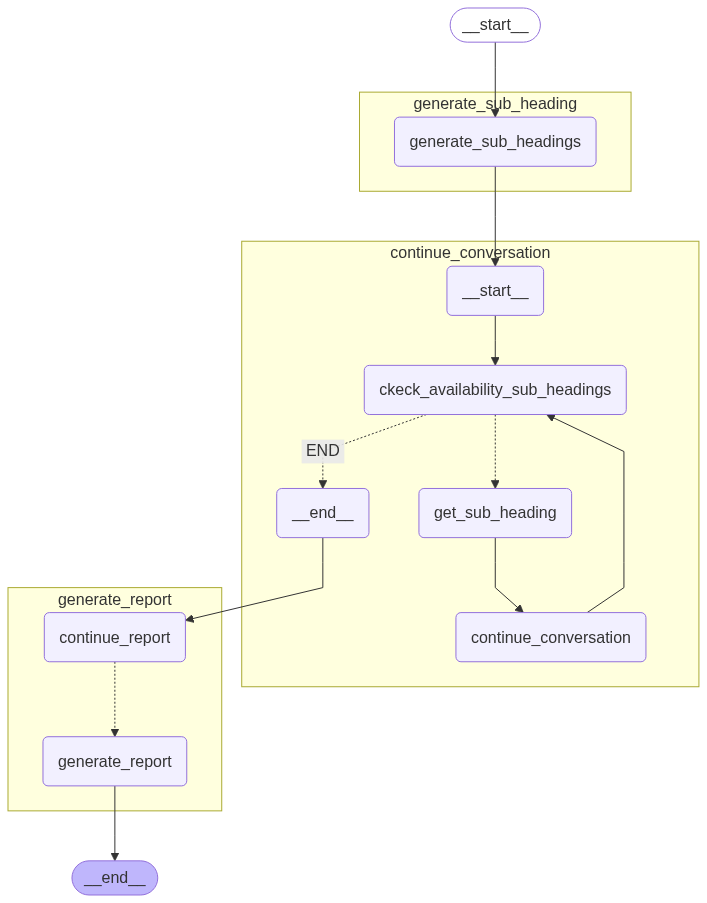

In [26]:
# connect both sub graphs
entry_builder = StateGraph(SubHeadingState)
entry_builder.add_node("generate_sub_heading",GenerateSubHeadingBuilder.compile())
entry_builder.add_node("continue_conversation",ContinueConversationBuilder.compile())
entry_builder.add_node("generate_report", ReportBuilder.compile())

# make the connections between sub graphs
entry_builder.add_edge(START, "generate_sub_heading")
entry_builder.add_edge("generate_sub_heading", "continue_conversation")
entry_builder.add_edge("continue_conversation", "generate_report")
entry_builder.add_edge("generate_report", END)

graph = entry_builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [27]:
# sample graph invoke
thread = {"configurable": {"thread_id": "1"},"recursion_limit":50}
graph.invoke({"messages": [HumanMessage(content="I want to build a website healthcare")], "max_generated_sub_headings": 10}, thread)

[HumanMessage(content='I want to build a website healthcare', additional_kwargs={}, response_metadata={}, id='6bc43b91-9f3b-4cb9-8184-61c952905f40')]
assistant:  Who is your target audience for this healthcare website?
user:  i want to target patients and doctors
[HumanMessage(content='I want to build a website healthcare', additional_kwargs={}, response_metadata={}, id='6bc43b91-9f3b-4cb9-8184-61c952905f40'), AIMessage(content='Who is your target audience for this healthcare website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--00a304a5-2b2a-4c27-b918-e8f6c4bb98bc-0', usage_metadata={'input_tokens': 36, 'output_tokens': 11, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='i want to target patients and doctors', additional_kwargs={}, response_metadata={}, id='43d02751-cea2-4879-8819-c679f4576d6c')

{'messages': [HumanMessage(content='I want to build a website healthcare', additional_kwargs={}, response_metadata={}, id='6bc43b91-9f3b-4cb9-8184-61c952905f40'),
  AIMessage(content='Who is your target audience for this healthcare website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--00a304a5-2b2a-4c27-b918-e8f6c4bb98bc-0', usage_metadata={'input_tokens': 36, 'output_tokens': 11, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='i want to target patients and doctors', additional_kwargs={}, response_metadata={}, id='43d02751-cea2-4879-8819-c679f4576d6c'),
  AIMessage(content='What specific problem are you trying to solve for patients and doctors with this website?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'mod

### Unit Testing for notebook

This ensure the written functions are giving correct outputs

In [ ]:
import unittest
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class TestFunctions(unittest.TestCase):

    def test_generated_sub_heading_type(self):
        
        # generate sub heading based on input 
        generate_query_instructions = """You are an caller agent user call for specific need.
                                 
                                 So you need do identify sub parts of the user need and generate sub part headings for get good understand about user need.

                                 You need to generate maximum {max_sub_parts} sub parts to get clear understand about user need.
                                 
                                 """
        
        # Make the system message
        system_message = generate_query_instructions.format(max_sub_parts=5)

        # Enforce structured output
        structured_llm = llm.with_structured_output(Perspectives)

        # Generate question 
        queries = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate sub part headings.")]+ [HumanMessage(content="I want to build a website")])

        # check for the type
        self.assertIsInstance(queries.sub_headings,list)
        for item in queries.sub_headings:
            self.assertIsInstance(item, GeneratedSubHeading)

    def test_continue_conversation(self):

        # this function continue the chat with user with different sub headings
        generate_question = """You are an caller agent user call for specific need.
                                    
                                you need consider about the chat messages previous and align with chat history.

                                you need to ask a question from user based on {current_focus}.
                                    
                                """
        
        # history messages
        messages = [HumanMessage(content='I want to build a web app on sport news', additional_kwargs={}, response_metadata={}, id='ccde5465-9521-4b3d-ba2a-9bdc585b8c36')]
        
        # make the system message to 
        system_message = generate_question.format(current_focus='App Functionality')

        # invoke the model with the history 
        question = llm.invoke(messages+ [system_message])
        # print("assistant: ",question.content)
        print(question)
        # check for the type
        self.assertIsInstance(question.content, str)


# run the unit tests
if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)
